## EPOPs for Various Groups by Gender, Age, Education

This notebook aims to calculate the employment to population ratio for each year since 1980 for each group by gender, age (16-24, 25-34, 35-44, 45-54, 55-64, and 65+), and education (less than high school, high school diploma, some college, college, advanced degress).

The source data is the [CEPR uniform data extracts based on the CPS Outgoing Rotation Group (ORG)](http://ceprdata.org/cps-uniform-data-extracts/cps-outgoing-rotation-group/). 

See EPOPS_example.ipynb as a proof of concept that the basic strategy for summarizing the microdata from the CPS will match with the BLS summary statistics.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('axes', edgecolor='white')
plt.rc('axes', axisbelow=True)

%matplotlib inline

In [2]:
# Which columns to keep
cols = ['year', 'female', 'age', 'educ', 'empl', 'fnlwgt']

# Male = 0, Female = 1
gender = {'Male': 0, 'Female': 1}

# Expand years once full data is in place
years = range(1980, 2017)

# Age groups (110 used just as max value)
ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 110)]

# Education level
educs = ['LTHS', 'HS', 'Some college', 'College', 'Advanced']

#### Looping through CEPR CPS ORG datasets and storing results

Filter by criteria listed above to identify the weighted total and employed populations for each group. Next calculate ratio of employed to population.

In [3]:
data = pd.DataFrame()
for y in years:
    filename = 'data/cepr_org_{}.dta'.format(y)
    df = pd.read_stata(filename, columns=cols)
    for g, gn in gender.items():
        for start, end in ages:
            a = '{}-{}'.format(start, end)
            if start == 65:
                a = '65+'
            for e in educs:
                # The next lines filter by age, gender, and
                # education, calculate the employed and total
                # for each group, and the ratio of employed
                # to group population
                dft = df[(df['age'] >= start) & 
                        (df['age'] <= end) &
                        (df['female'] == gn) & 
                        (df['educ'] == e)]
                emp = dft.groupby('empl').sum()['fnlwgt'].ix[1]
                pop = dft.groupby('empl').sum()['fnlwgt'].sum()
                epop = emp/pop
                # Generate group description column name
                cname = '{}: {}: {}'.format(g, a, e)
                data.set_value(y, cname, epop)

In [4]:
data.to_csv('results/epops_clean.csv')

In [5]:
data2016 = pd.DataFrame()
filename = 'data/cepr_org_2016.dta'
df = pd.read_stata(filename, columns=cols)
y = 2016
N2016 = df['fnlwgt'].sum()
for g, gn in gender.items():
    for start, end in ages:
        a = '{}-{}'.format(start, end)
        if start == 65:
            a = '65+'
        for e in educs:
            dft = df[(df['age'] >= start) & 
                    (df['age'] <= end) &
                    (df['female'] == gn) & 
                    (df['educ'] == e)]
            pop = int(round(dft.groupby('empl').sum()['fnlwgt'].sum()))
            cname = '{}: {}: {}'.format(g, a, e)
            data2016.set_value(y, cname, pop)

data1980 = pd.DataFrame()
filename = 'data/cepr_org_1980.dta'
df = pd.read_stata(filename, columns=cols)
y = 1980
N1980 = df['fnlwgt'].sum()
for g, gn in gender.items():
    for start, end in ages:
        a = '{}-{}'.format(start, end)
        if start == 65:
            a = '65+'
        for e in educs:
            dft = df[(df['age'] >= start) & 
                    (df['age'] <= end) &
                    (df['female'] == gn) & 
                    (df['educ'] == e)]
            pop = int(round(dft.groupby('empl').sum()['fnlwgt'].sum()))
            cname = '{}: {}: {}'.format(g, a, e)
            data1980.set_value(y, cname, pop)

#### Plotting the results

Generate a small plot of each EPOP rate

In [6]:
data = pd.read_csv('results/epops_clean.csv', index_col=0, parse_dates=True)

C:\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


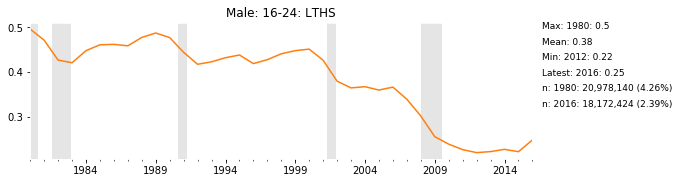

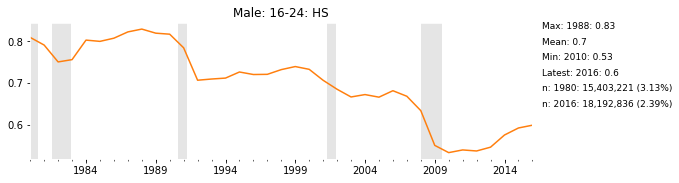

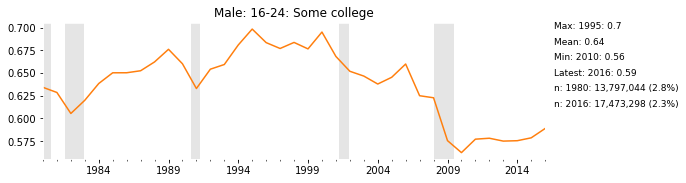

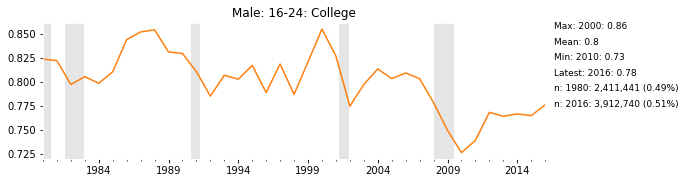

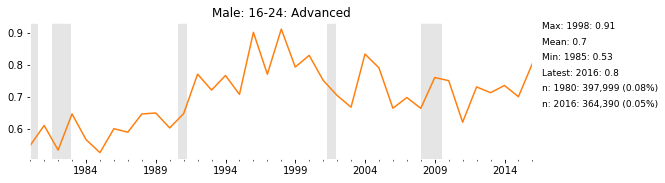

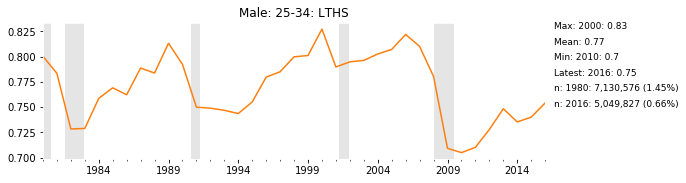

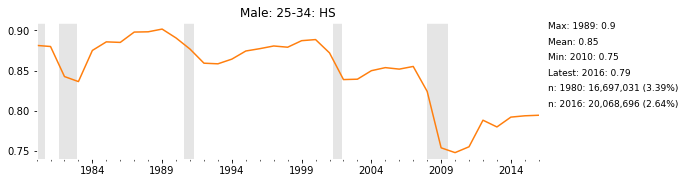

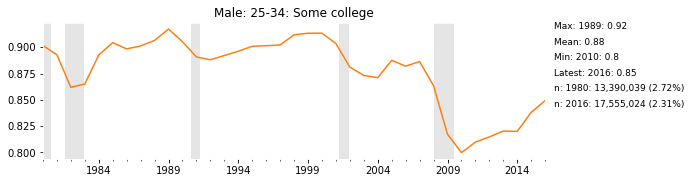

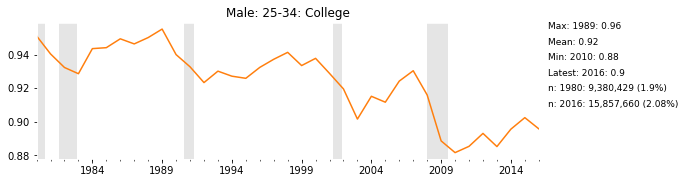

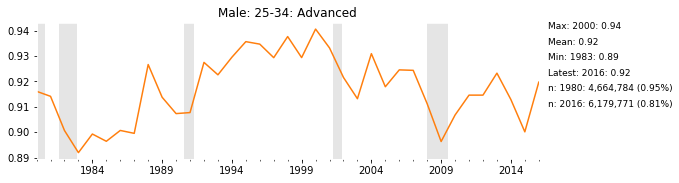

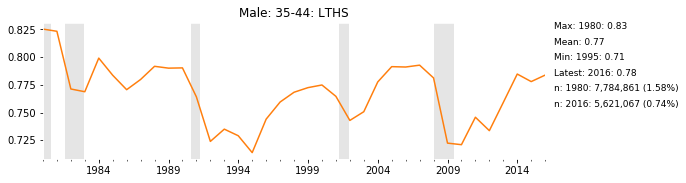

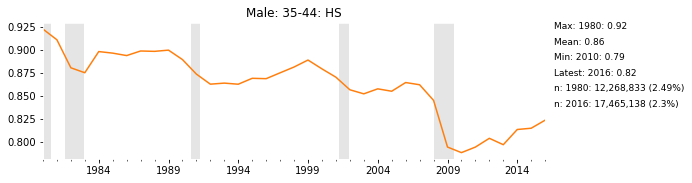

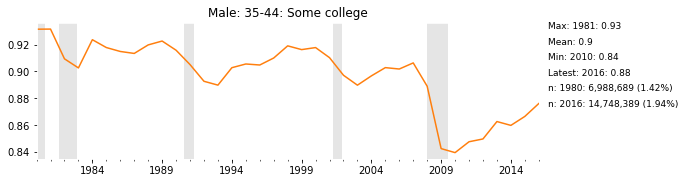

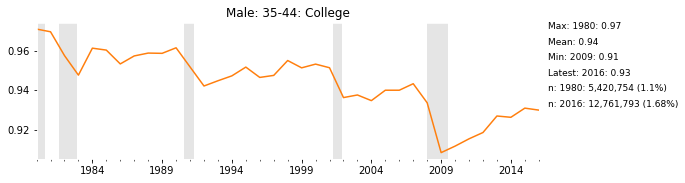

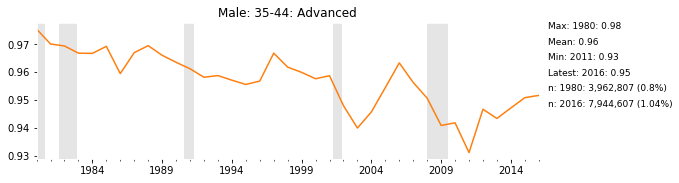

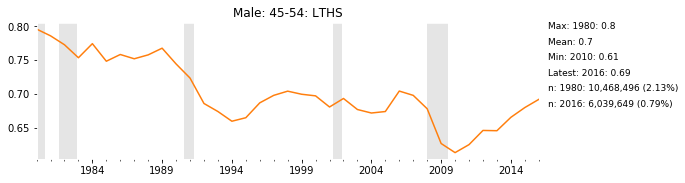

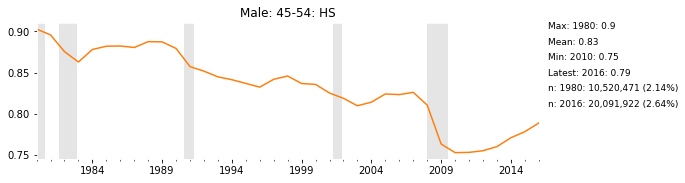

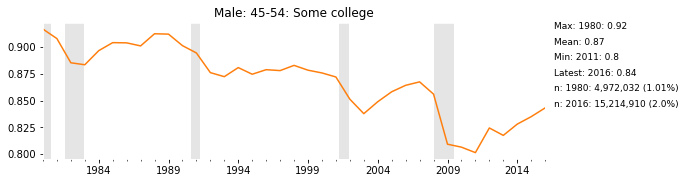

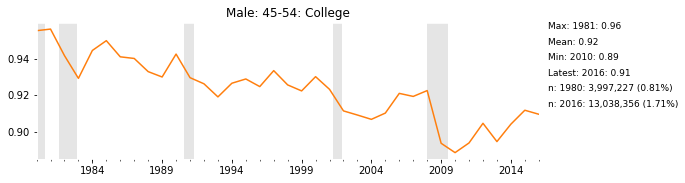

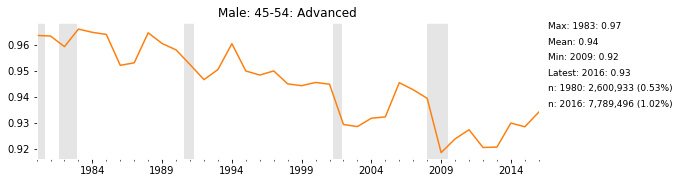

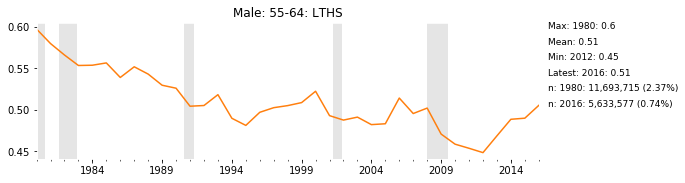

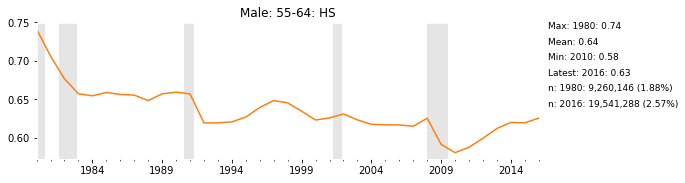

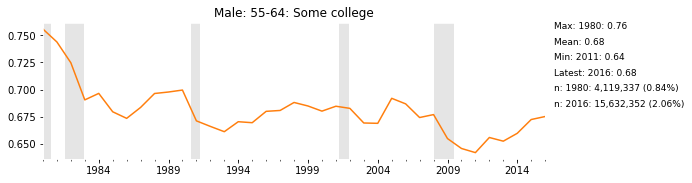

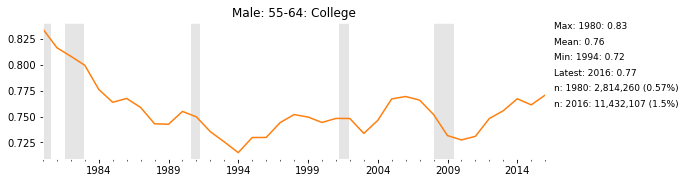

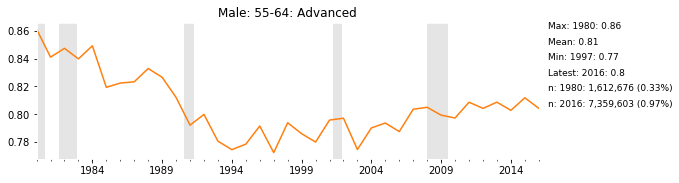

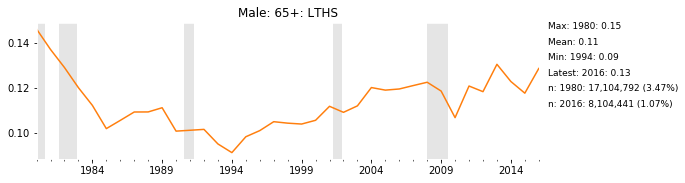

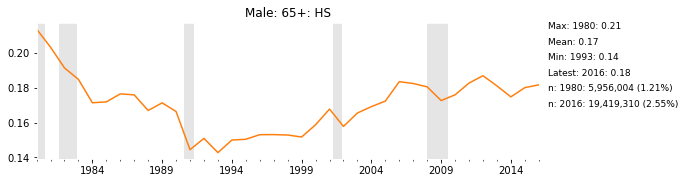

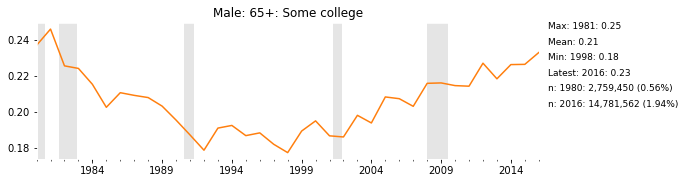

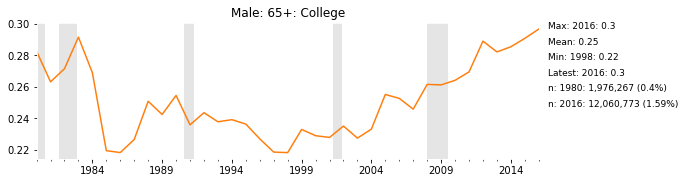

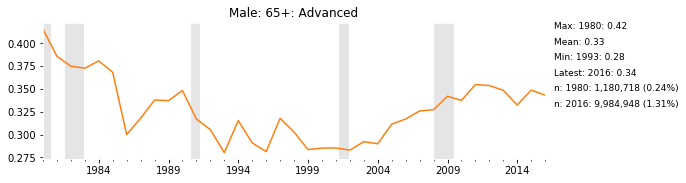

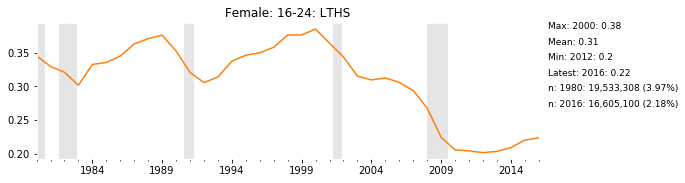

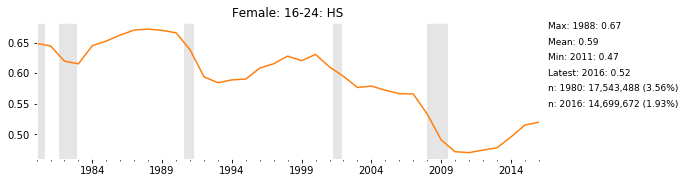

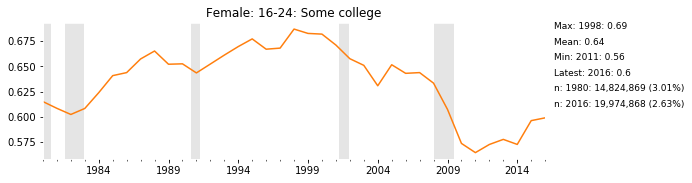

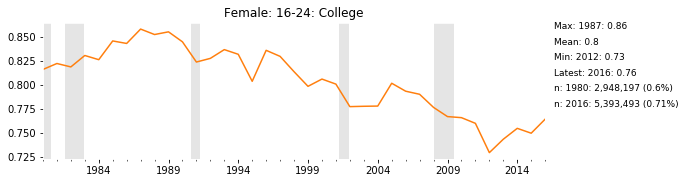

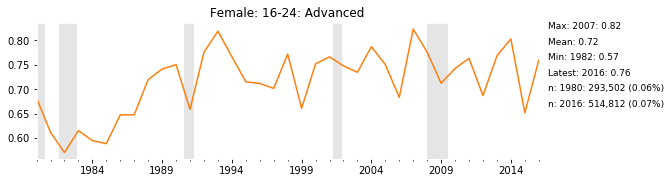

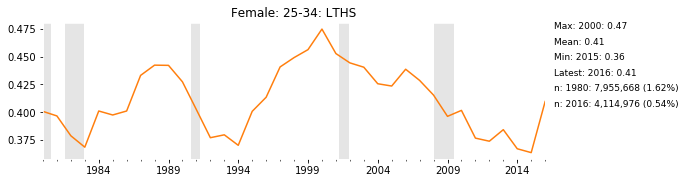

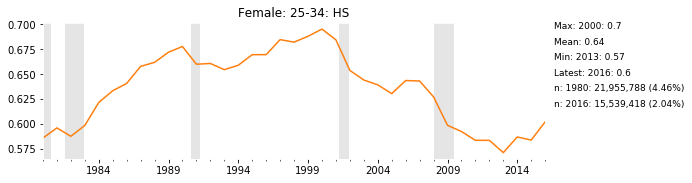

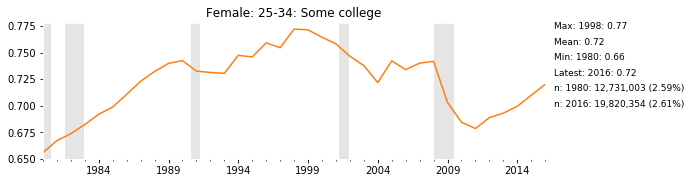

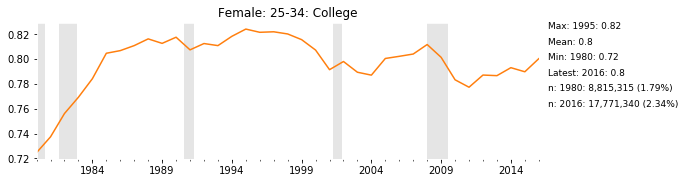

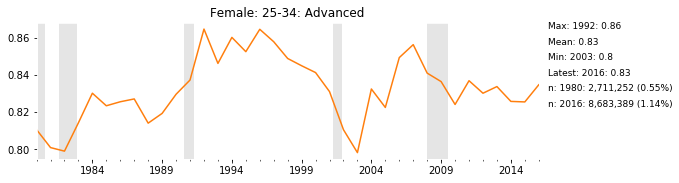

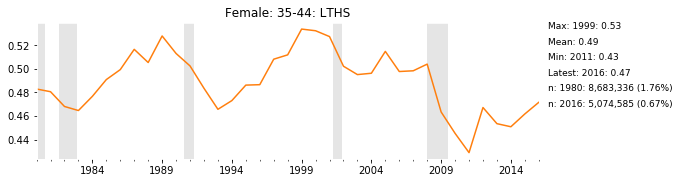

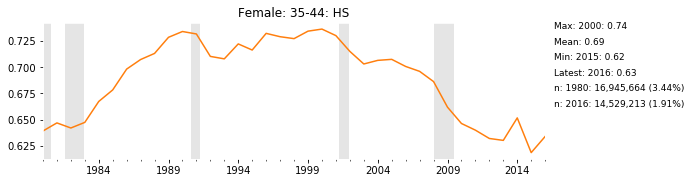

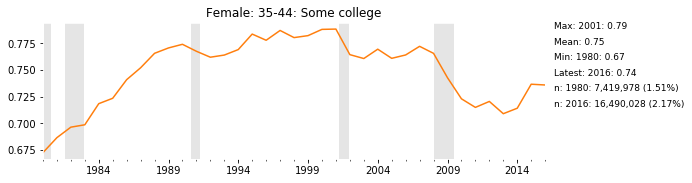

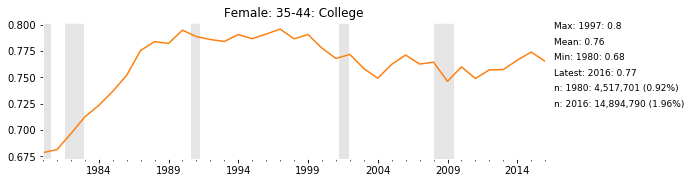

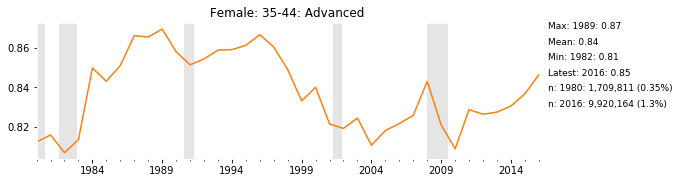

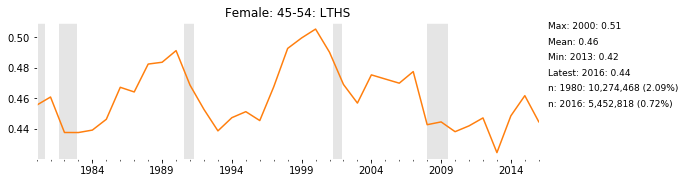

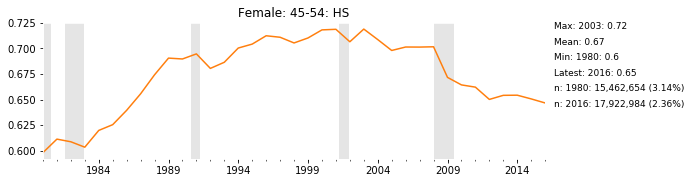

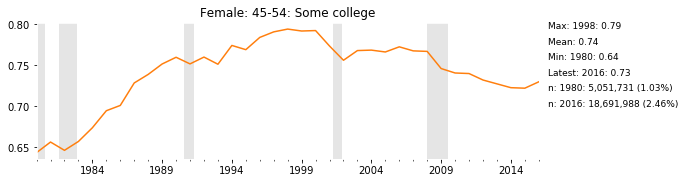

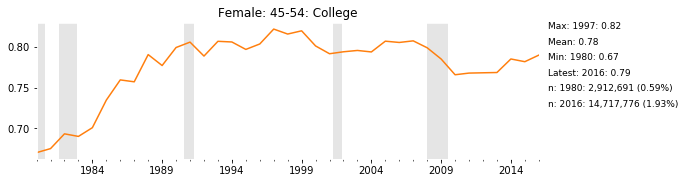

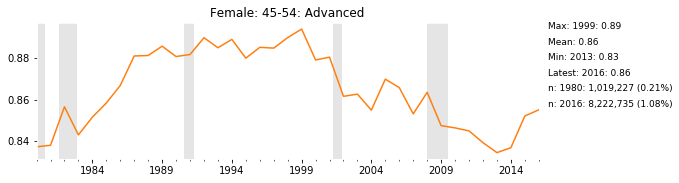

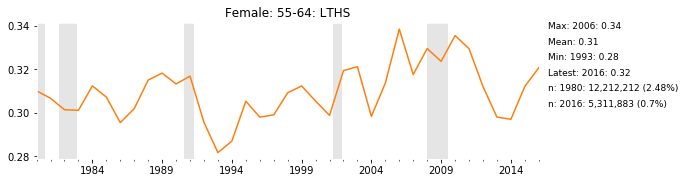

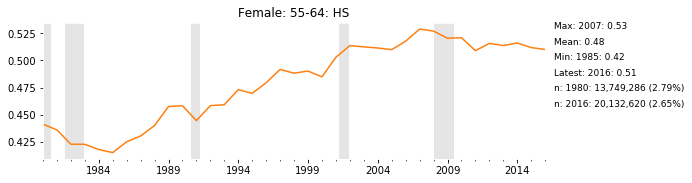

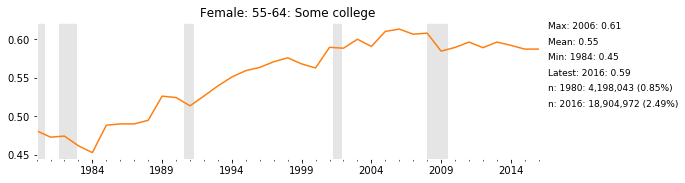

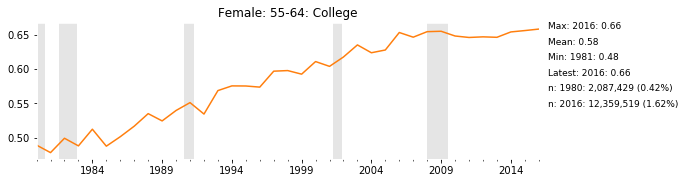

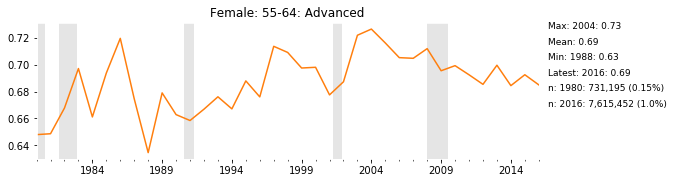

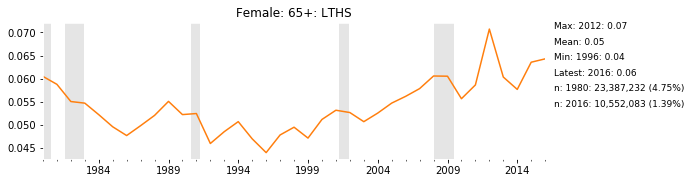

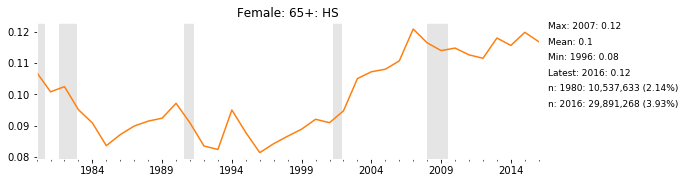

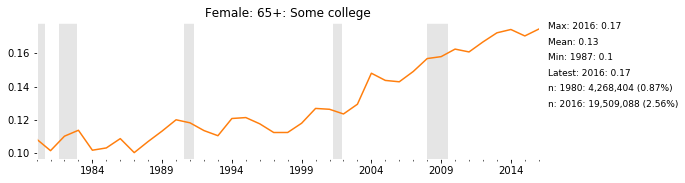

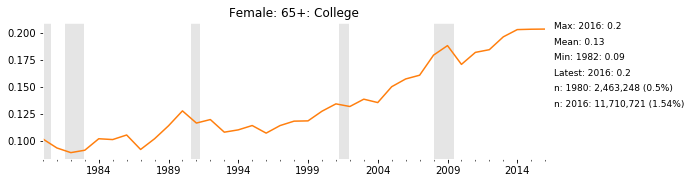

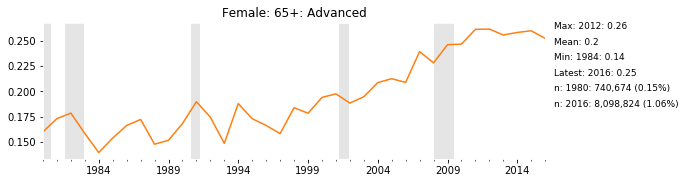

In [7]:
for name, values in data.iteritems():
    mean = round(values.mean(),2)
    maxv = round(values.max(),2)
    maxy = values.idxmax().year
    minv = round(values.min(),2)
    miny = values.idxmin().year
    latest = round(values[-1],2)
    n2016 = int(data2016.loc[2016, name])
    nN2016 = round((n2016/N2016) * 100, 2)
    n1980 = int(data1980.loc[1980, name])
    nN1980 = round((n1980/N1980) * 100, 2)
    space = (values.max() - values.min()) / 8
    
    temp_df = pd.DataFrame([values.mean()] * 433)
    temp_df = temp_df.set_index(pd.date_range(start='1/1/1980', end='1/1/2016', freq='MS'))
    temp_df.plot(alpha=0, legend=False)

    # Plot one series as example:
    values.plot(figsize=(9, 2.5), 
               title=name)
    # Shaded bars indicating recessions
    for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
        plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='gray', alpha=0.2)
        
    plt.text(560, values.max(), 'Max: {}: {}'.format(maxy, maxv), size=9)
    plt.text(560, values.max() - space, 'Mean: {}'.format(mean), size=9)
    plt.text(560, values.max() - (space*2), 'Min: {}: {}'.format(miny, minv), size=9)
    plt.text(560, values.max() - (space*3), 'Latest: 2016: {}'.format(latest), size=9)
    plt.text(560, values.max() - (space*4), 'n: 1980: {:,} ({}%)'.format(n1980, nN1980), size=9)
    plt.text(560, values.max() - (space*5), 'n: 2016: {:,} ({}%)'.format(n2016, nN2016), size=9)